In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('bhaveshmittal/melanoma-cancer-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'melanoma-cancer-dataset' dataset.
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#dataset loading

In [ ]:
import os
import pandas as pd
import numpy as np


from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
OD = OrdinalEncoder(categories= [['Benign', 'Malignant']])
LABEL = ['Benign', 'Malignant']

In [ ]:
x_train = pd.read_csv('/content/melanoma-cancer-dataset_x_train.csv')
y_train = pd.read_csv('/content/melanoma-cancer-dataset_y_train.csv')

x_val = pd.read_csv('/content/melanoma-cancer-dataset_x_val.csv')
y_val = pd.read_csv('/content/melanoma-cancer-dataset_y_val.csv')

x_test = pd.read_csv('/content/melanoma-cancer-dataset_x_test.csv')
y_test = pd.read_csv('/content/melanoma-cancer-dataset_y_test.csv')

In [ ]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
print(y_train.value_counts())
needed = 3418 - 1266
print('___________')
print(needed)

label    
Benign       5831
Malignant    1600
Name: count, dtype: int64
___________
2152


In [ ]:
def images_show(index_list, x, y):
    x_col = x.iloc[:, 0] if hasattr(x, "iloc") else x
    y_col = y.iloc[:, 0] if hasattr(y, "iloc") else y

    images = []
    for idx in index_list:
        img_path = x_col.iloc[idx] if hasattr(x_col, "iloc") else x_col[idx]
        image = load_img(img_path, target_size=(150,150))
        images.append(image)

    plt.figure(figsize=(60, 45))
    for j, im in enumerate(images):
        idx = index_list[j]
        label = y_col.iloc[idx] if hasattr(y_col, "iloc") else y_col[idx]
        plt.subplot(5, 5, j+1)
        plt.imshow(im)
        plt.title(f"{idx} : {label}", fontsize=60)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


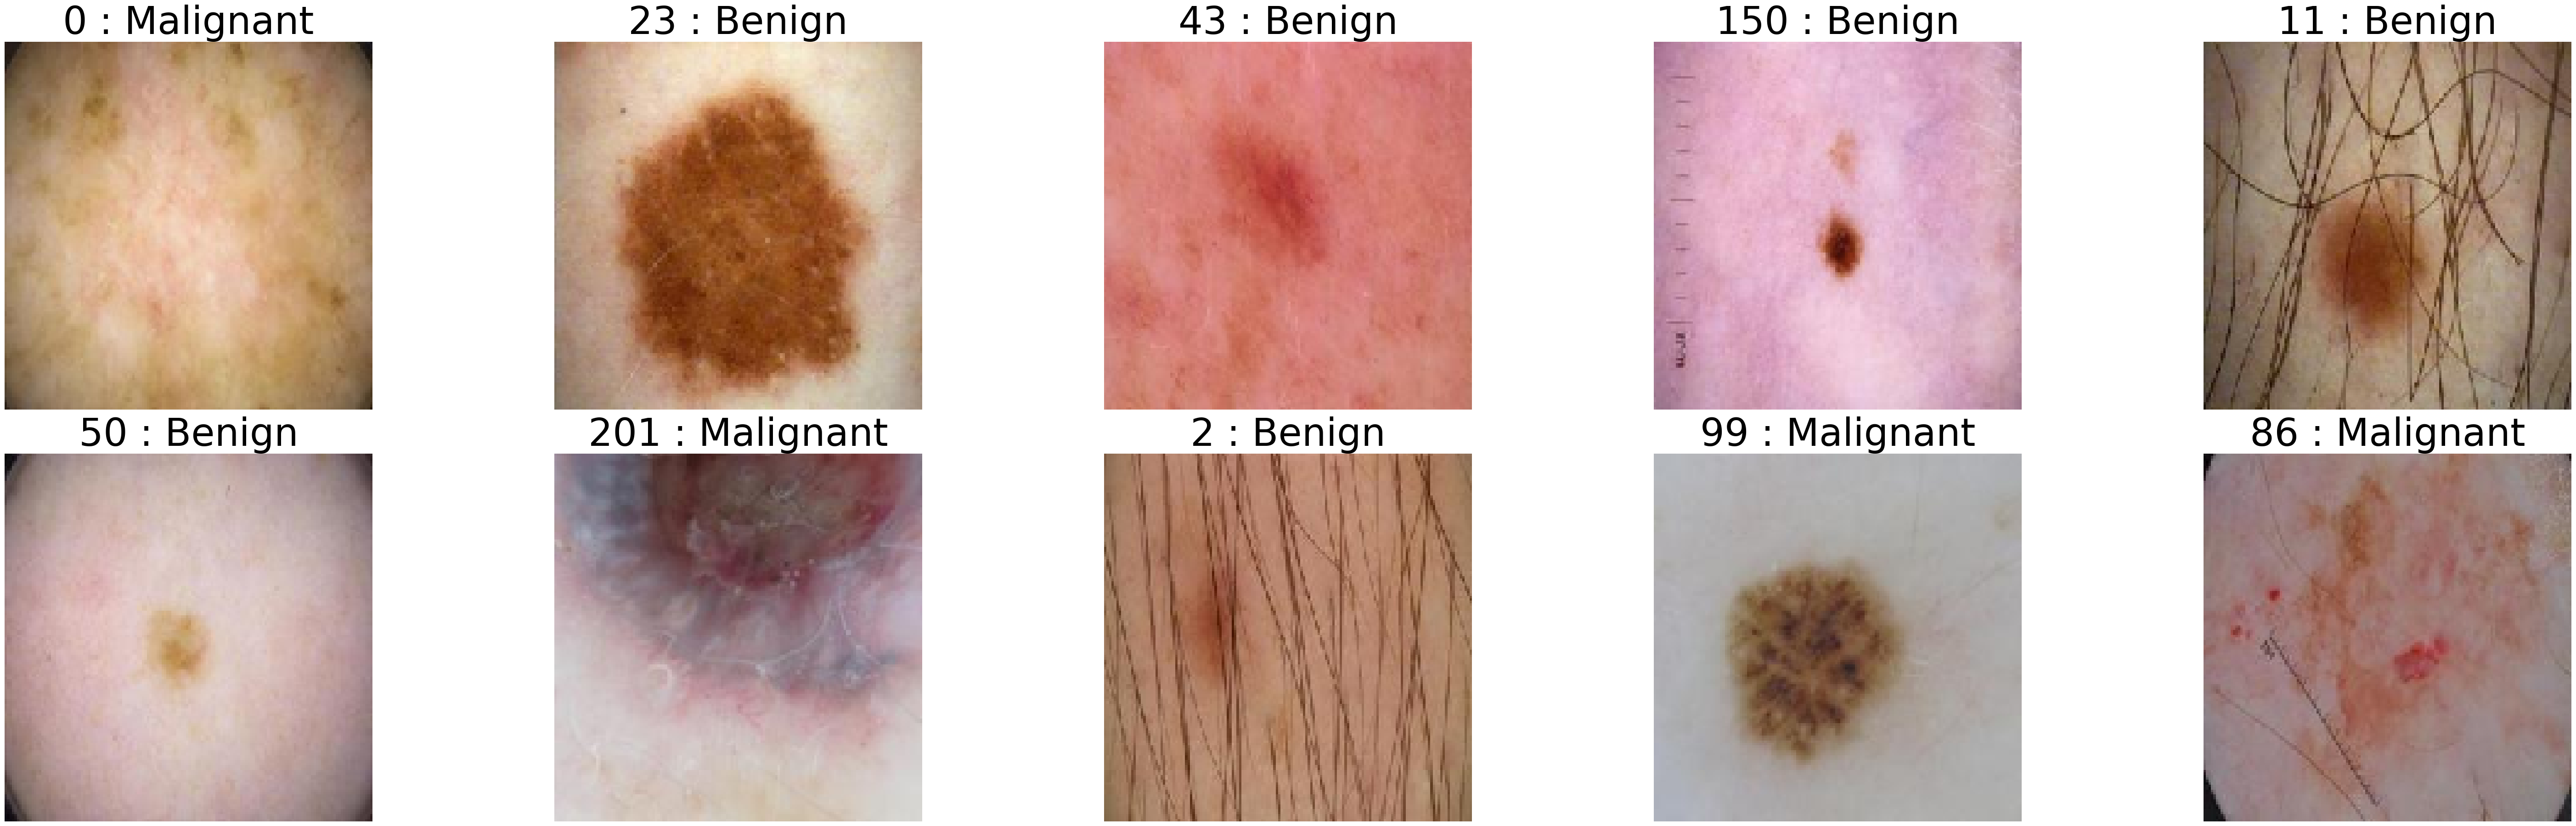

In [ ]:
# showing a sample from x_train ,any number between 0 - 201
images_show(index_list=[0, 23, 43, 150,
            11, 50,  201, 2, 99, 86], x=x_train, y=y_train)

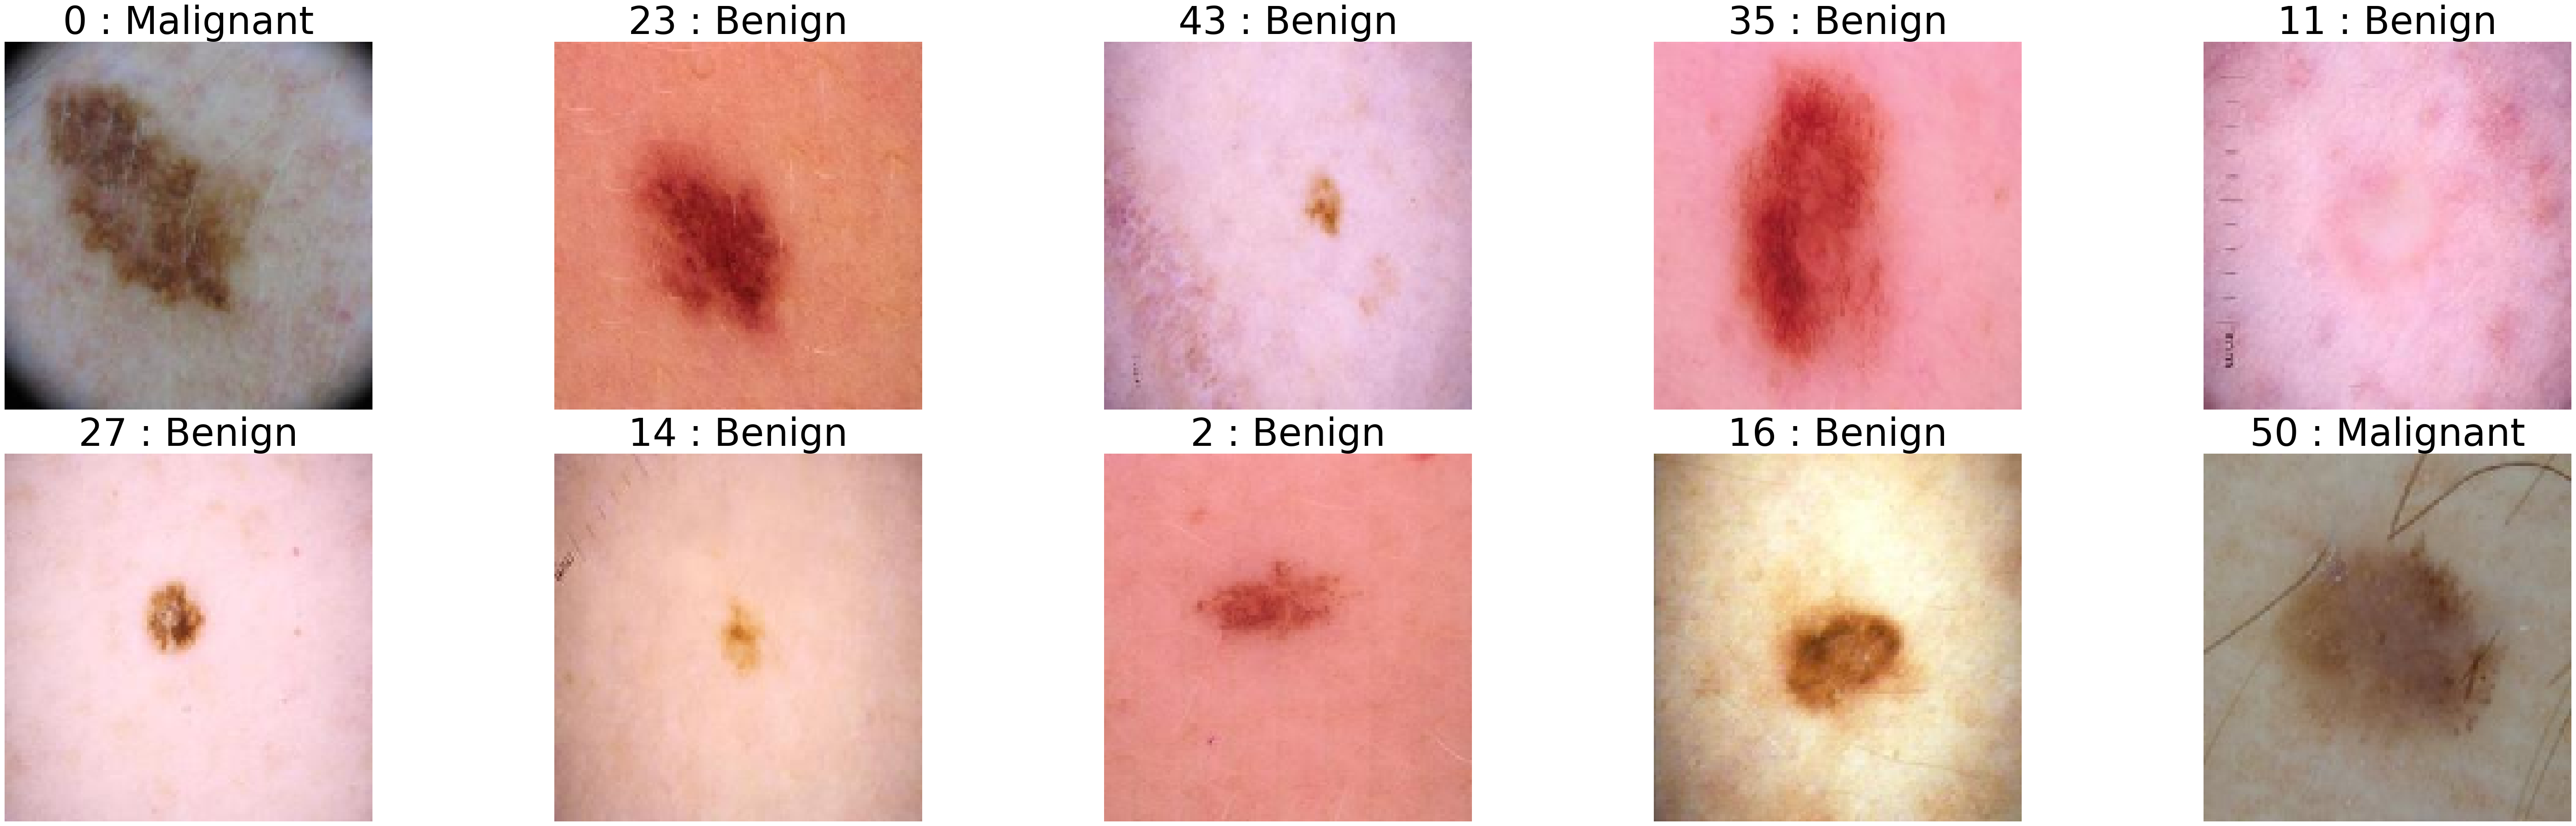

In [ ]:
# showing a sample from x_test ,any number between 0 - 50
images_show(index_list=[0, 23, 43, 35,
            11, 27,  14, 2, 16, 50], x=x_test, y=y_test)

In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array

def Array_con(df, target_size=(64,64)):
    paths = df["path"].astype(str).tolist()

    arr = []
    missing = []
    for p in paths:
        if not os.path.exists(p):
            missing.append(p)
            continue
        img = load_img(p, target_size=target_size)
        arr.append(img_to_array(img))

    if len(arr) == 0:
        print("Example missing path:", missing[0] if missing else "None")
        raise ValueError("No images loaded. Your paths don't exist in this runtime.")

    print(f"Loaded {len(arr)} images, skipped {len(missing)} missing.")
    return np.array(arr, dtype=np.float32)


In [ ]:
x_train = Array_con(x_train)
x_val = Array_con(x_val)
x_test = Array_con(x_test)

Loaded 7431 images, skipped 0 missing.
Loaded 4644 images, skipped 0 missing.
Loaded 4645 images, skipped 0 missing.


In [ ]:
x_train.shape

(7431, 64, 64, 3)

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
y_test

,label
0,Malignant
1,Benign
2,Benign
3,Malignant
4,Benign
...,...
4640,Benign
4641,Benign
4642,Benign
4643,Benign


In [ ]:
# applying "OD"

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)


y_train = OD.fit_transform(y_train)
y_test = OD.transform(y_test)

#Vanilla GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam , SGD, AdamW, Adadelta
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.regularizers import l2
import keras
from keras import ops

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

## Override `train_step`

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([real_images, generated_images], axis=0)


        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.ones((batch_size, 1))


        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Normalize the data

In [ ]:
import numpy as np
import tensorflow as tf

y_train_np = np.asarray(y_train).reshape(-1).astype(np.int32)
x_train_np = np.asarray(x_train)  # this is already images: (N,64,64,3)

minor_class = 0
x_min = x_train_np[y_train_np == minor_class]
print("minor samples:", x_min.shape)


batch_size = 50
ds_min = (tf.data.Dataset.from_tensor_slices(x_min)
          .shuffle(min(2000, len(x_min)))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


minor samples: (5831, 64, 64, 3)


In [ ]:
for b in ds_min.take(1):
    print(b.dtype, float(tf.reduce_min(b)), float(tf.reduce_max(b)))


<dtype: 'float32'> 0.0 1.0


In [ ]:
epochs = 40  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(2.5e-5, beta_1=0.5, beta_2=0.999),
    g_optimizer = tf.keras.optimizers.Adam(2.5e-5, beta_1=0.5, beta_2=0.999),
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

)

gan.fit(
    ds_min, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - d_loss: 0.6667 - g_loss: 0.6041
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.5742 - g_loss: 0.7819
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6910 - g_loss: 0.8381
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.5286 - g_loss: 1.1739
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.5899 - g_loss: 0.9216
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6088 - g_loss: 0.8193
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6268 - g_loss: 0.7987
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6068 - g_loss: 0.7849
Epoch 9/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6715 - g_loss: 0.6421
Epoch 10/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6920 - g_loss: 0.6090
Epoch 11/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - d_loss: 0.6870 - g_loss: 0.6125
Epoch 12/40
117/117 ━━━━━━━━━━━━━━━━━━━

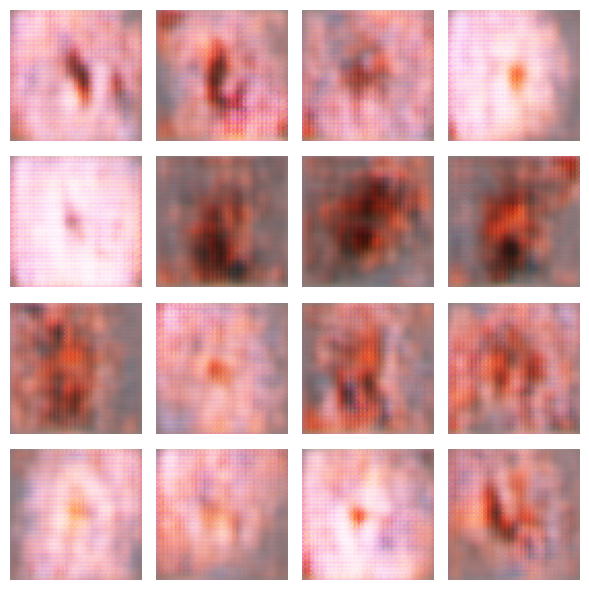

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

n = 16
z = tf.random.normal((n, latent_dim))
fake = generator(z, training=False).numpy()      # [0,1] because sigmoid

plt.figure(figsize=(6,6))
for i in range(n):
    plt.subplot(4,4,i+1)
    plt.imshow(fake[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Generate new data

In [ ]:
N_real = x_min.shape[0]
N_fake = int(0.5 * N_real)


In [ ]:
z = tf.random.normal((N_fake, latent_dim))
x_fake = generator(z, training=False).numpy()
y_fake = np.full((N_fake,), minor_class)


In [ ]:
print("y_train shape:", np.asarray(y_train).shape)
print("y_fake shape:", np.asarray(y_fake).shape)


print("x_train shape:", np.asarray(x_train).shape)
print("x_fake shape:", x_fake.shape)



y_train shape: (7431, 1)
y_fake shape: (2915,)
x_train shape: (7431, 64, 64, 3)
x_fake shape: (2915, 64, 64, 3)


In [ ]:
import numpy as np

# Fix labels shape
y_train_np = np.asarray(y_train).reshape(-1).astype(int)   # (4684,)
y_fake = np.asarray(y_fake).reshape(-1).astype(int)        # (633,)

# Concatenate
x_train_bal = np.concatenate([x_train, x_fake], axis=0)
y_train_bal = np.concatenate([y_train_np, y_fake], axis=0)

print("x_train_bal:", x_train_bal.shape)
print("y_train_bal:", y_train_bal.shape)


x_train_bal: (10346, 64, 64, 3)
y_train_bal: (10346,)


In [ ]:
#shuffle

idx = np.random.permutation(len(x_train_bal))
x_train_bal = x_train_bal[idx]
y_train_bal = y_train_bal[idx]

# now the data is dalanced and shuffled

## Evaluating vanilla GAN

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - binary_accuracy: 0.7699 - loss: 0.5011 - val_binary_accuracy: 0.7847 - val_loss: 0.4912
Epoch 2/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8451 - loss: 0.4103 - val_binary_accuracy: 0.7847 - val_loss: 0.4798
Epoch 3/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8510 - loss: 0.3822 - val_binary_accuracy: 0.8071 - val_loss: 0.4249
Epoch 4/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8674 - loss: 0.3450 - val_binary_accuracy: 0.8224 - val_loss: 0.3918
Epoch 5/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8708 - loss: 0.3281 - val_binary_accuracy: 0.8273 - val_loss: 0.3889
Epoch 6/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8765 - loss: 0.3065 - val_binary_accuracy: 0.8400 - val_loss: 0.3573
Epoch 7/60
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_accuracy: 0.8792 - loss: 0.2974 - val_binary_accuracy: 0.8482 - val_loss: 0.3441
Epoch

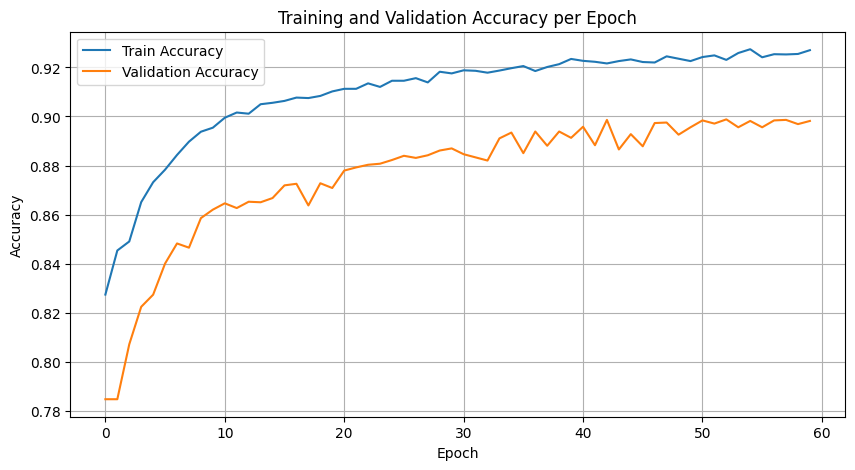

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      3645
         1.0       0.83      0.66      0.74      1000

    accuracy                           0.90      4645
   macro avg       0.87      0.81      0.84      4645
weighted avg       0.89      0.90      0.89      4645


Confusion Matrix:


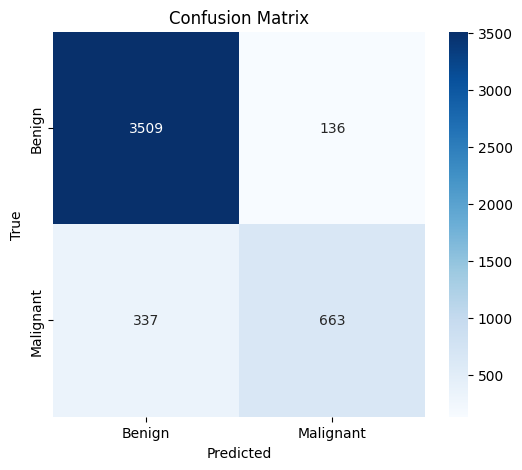

In [ ]:
model_vanilla_gan = models.Sequential([
    layers.Conv2D(16, (3, 3), strides=(1,1) ,activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPool2D(),
    layers.Conv2D(4, (3, 3), strides=(1,1) , activation='relu'),

    layers.Conv2D(4, (3, 3), strides=(1,1) , activation='relu'),
    layers.AveragePooling2D((1,1)),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


model_vanilla_gan.compile(optimizer= Adam(learning_rate=0.0001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model_vanilla_gan.fit(x_train_bal, y_train_bal,
                    epochs=60,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])


test_loss, test_accuracy = model_vanilla_gan.evaluate(x_test, y_test)
final_train_acc = history.history['binary_accuracy'][-1]

print(f"\nFinal Train Accuracy: {final_train_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




# Predict on test data
y_prob = model_vanilla_gan.predict(x_test).ravel()      # probabilities in [0,1]
y_pred = (y_prob >= 0.5).astype(int)        # class 0/1


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL, yticklabels=LABEL)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()